This is a walkthrough to create the model

First we have to define all functions that we use at a later stage

In [7]:
import sys, os, shutil, logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt

from tqdm.keras import TqdmCallback

import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Lambda
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

import numpy as np

print("Current environment binary: ", sys.executable)

print("Is CUDA enabled?: ", tf.test.is_built_with_cuda())

print("NVCC Version Information:")

# Überprüfen Sie die installierte CUDA-Version.
!nvcc --version

logging.getLogger('absl').setLevel(logging.ERROR)

##############################################
learning_rate = 0.1  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.5  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = './data'  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = 'output_files'  # root folder in which to save the output files; the files will be under output_files/model_name 
##############################################

@tf.function
def convert_to_hsv_and_grayscale(x):
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez


def network(input_shape: any, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(convert_to_hsv_and_grayscale)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

def plot_model_history(model_history: object, out_path=""):
    """
    Plot the accuracy and loss history of a model.

    :param model_history: The history object of a trained model.
    :type model_history: object
    :param out_path: The directory to save the plot. If not provided, the plot will be displayed instead.
    :type out_path: str
    :return: None
    :rtype: None
    """
    fig, axs = plt.subplots(1, 2)
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history.get('val_accuracy', [])) + 1),
                model_history.history.get('val_accuracy', []))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(range(1, len(model_history.history['accuracy']) + 1))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history.get('val_loss', [])) + 1), model_history.history.get('val_loss', []))
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(range(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')
    
    # Save the plot if out_path is provided
    if out_path:
        plt.savefig(out_path + "/accuracy_loss_plot.png")
        with open(out_path + "/model_history.txt", "w") as f:
            for key, value in model_history.history.items():
                f.write(f"{key}: {value}\n")
    plt.tight_layout()  # Add this line
    plt.show()



def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    
    # Adjusting figure size based on the number of classes
    num_classes = len(classes)
    figsize = (min(num_classes * 2, 20), min(num_classes * 2, 20))
    plt.figure(figsize=figsize)
    
    # Plotting the heatmap
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    
    # Adjusting font size for readability
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    
    # Saving the plot if out_path is provided
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")
        np.savetxt(out_path + "/confusion_matrix.txt", cm, fmt='%d', header=" ".join(classes), comments='')
    plt.tight_layout()  # Add this line
    plt.show()
    return ax


@tf.function
def augment_image(x):
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    return x


def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100),
                          batch_size=50):
    """
    Build data generators for training, validation, and testing.

    :param train_folder: The path to the training data folder.
    :type train_folder: str
    :param test_folder: The path to the testing data folder.
    :type test_folder: str
    :param validation_percent: The percentage indicating how much of the training set
        should be kept for validation.
    :type validation_percent: float
    :param labels: The list of labels. Default is None.
    :type labels: list or None
    :param image_size: The target size of the images. Default is (100, 100).
    :type image_size: tuple
    :param batch_size: The number of samples per batch. Default is 50.
    :type batch_size: int
    :return: The data generators for training, validation, and testing.
    :rtype: tuple
    """
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  # randomly flip images
        preprocessing_function=augment_image,
        validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training',
                                                  classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation',
                                                       classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen

class CustomModelCheckpoint(Callback):

    def __init__(self, filepath, monitor='accuracy', verbose=1, mode='max', save_best_only=True):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.save_best_only = save_best_only
        if self.save_best_only:
            if self.mode == 'min':
                self.best = np.Inf
            elif self.mode == 'max':
                self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        print(f"Logs during epoch end {logs}")
        current_value = logs.get(self.monitor)
        self.best = current_value
        self.model.save(self.filepath)
        print(f"Model saved successfully at {self.filepath}")

# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, name="", epochs=50, batch_size=29, verbose=1, useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir, name)
    
    folder = model_out_dir
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        load_model(model_out_dir + "/model.tf")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels,
                                                             image_size=image_size, batch_size=batch_size)
    optimizer = Adadelta(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose,
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    
    print(f"Model will be saved in: {model_out_dir}")
    print("Does the output directory exist?", os.path.isdir(model_out_dir))
    
    save_model = CustomModelCheckpoint(filepath=model_out_dir + "/model.tf", monitor='accuracy', verbose=verbose, mode='max', save_best_only=False)

    history = model.fit(trainGen,
                        epochs=epochs,
                        steps_per_epoch=(trainGen.n // batch_size) + 1,
                        validation_data=validationGen,
                        validation_steps=(validationGen.n // batch_size) + 1,
                        verbose=0,
                        callbacks=[learning_rate_reduction, save_model, TqdmCallback(verbose=1)])

    print(os.path.exists(model_out_dir + "/model.tf"))
    print(os.getcwd()) 

    try:
        model_path = model_out_dir + "/model.tf"
        print(f"Trying to load the model from: {model_path}")
        loaded_model = load_model(model_path)
    except Exception as e:
        print("Exception occurred while loading the model")
        print(e)

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    
    try:
        plot_model_history(history, out_path=model_out_dir)
    except Exception as e:
        print(f"An error occurred while plotting model history: {e}")
    testGen.reset()
    y_pred = model.predict(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    try:
        plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    except Exception as e:
        print(f"An error occurred while plotting confusion matrix: {e}")
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)
    # print(class_report)


TensorFlow version:  2.12.0
Current environment binary:  /home/marcel/miniconda3/envs/tensorflow_39_env/bin/python
Is CUDA enabled?:  False
NVCC Version Information:
/bin/bash: /home/marcel/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


Generate structural data and labels

In [8]:
import pandas as pd
import seaborn as sn
import os

from sklearn.metrics import confusion_matrix, classification_report

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)

print(labels)
print(num_classes)

['Apple Braeburn', 'Orange', 'Plum']
3


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data (InputLayer)           [(None, 100, 100, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 100, 100, 4)       0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 16)      1616      
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 50, 50, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 25, 25, 64)        5126

2024-02-17 23:58:05.866267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,100,100,3]
	 [[{{node Placeholder}}]]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-02-17 23:58:06.142783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 23:58:20.294823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Logs during epoch end {'loss': 5.672265529632568, 'accuracy': 0.6564944982528687, 'val_loss': 0.5883972644805908, 'val_accuracy': 0.7214285731315613, 'lr': 0.1}


2024-02-17 23:58:20.917173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:58:21.215126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:58:21.217373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.6113821268081665, 'accuracy': 0.8450704216957092, 'val_loss': 0.09522658586502075, 'val_accuracy': 0.9857142567634583, 'lr': 0.1}


2024-02-17 23:58:35.619880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:58:35.719249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:58:35.721673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.29936209321022034, 'accuracy': 0.9014084339141846, 'val_loss': 0.002426449442282319, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-17 23:58:49.924283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:58:50.008903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:58:50.016633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.36026841402053833, 'accuracy': 0.9162754416465759, 'val_loss': 0.003561692778021097, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-17 23:59:04.758563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:59:04.836992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:59:04.841745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.11459168791770935, 'accuracy': 0.9632238149642944, 'val_loss': 0.007809121161699295, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-17 23:59:18.961680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:59:19.034271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:59:19.041371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.19182240962982178, 'accuracy': 0.9452269077301025, 'val_loss': 0.0016337932320311666, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-17 23:59:32.460829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:59:32.550512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:59:32.551940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.037314604967832565, 'accuracy': 0.9890453815460205, 'val_loss': 0.001088823308236897, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-17 23:59:46.582590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-17 23:59:46.649431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-17 23:59:46.652121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.114467553794384, 'accuracy': 0.9671361446380615, 'val_loss': 0.0006222792435437441, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:00:00.668322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:00:00.748916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:00:00.760774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.028014322742819786, 'accuracy': 0.9906103014945984, 'val_loss': 0.00027039661654271185, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:00:15.407523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:00:15.509629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:00:15.511478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.05695812776684761, 'accuracy': 0.9843505620956421, 'val_loss': 0.004180672112852335, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:00:31.147266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:00:31.227902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:00:31.229369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0116538405418396, 'accuracy': 0.9960876107215881, 'val_loss': 6.58743956591934e-05, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:00:45.799328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:00:45.873577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:00:45.879182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.09794937074184418, 'accuracy': 0.9765258431434631, 'val_loss': 0.0003551708359736949, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:01:00.064900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:01:00.148681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:01:00.150399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.30223098397254944, 'accuracy': 0.9679186344146729, 'val_loss': 0.0008019604138098657, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:01:14.232314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:01:14.297761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:01:14.314315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
Logs during epoch end {'loss': 0.009797893464565277, 'accuracy': 0.9976525902748108, 'val_loss': 0.00011814095341833308, 'val_accuracy': 1.0, 'lr': 0.1}


2024-02-18 00:01:29.561782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:01:29.651073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:01:29.652887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0033484420273452997, 'accuracy': 1.0, 'val_loss': 0.00013736421533394605, 'val_accuracy': 1.0, 'lr': 0.05}


2024-02-18 00:01:44.004720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:01:44.089557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:01:44.097118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.004325686953961849, 'accuracy': 0.9992175102233887, 'val_loss': 0.0002546439354773611, 'val_accuracy': 1.0, 'lr': 0.05}


2024-02-18 00:01:59.169299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:01:59.269337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:01:59.271071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
Logs during epoch end {'loss': 0.00130174751393497, 'accuracy': 1.0, 'val_loss': 8.724357758183032e-05, 'val_accuracy': 1.0, 'lr': 0.05}


2024-02-18 00:02:14.010613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:02:14.077300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:02:14.079236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0004214422369841486, 'accuracy': 1.0, 'val_loss': 1.0570952326816041e-05, 'val_accuracy': 1.0, 'lr': 0.025}


2024-02-18 00:02:27.984912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:02:28.060334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:02:28.077969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0019041833002120256, 'accuracy': 0.9992175102233887, 'val_loss': 1.5220684872474521e-05, 'val_accuracy': 1.0, 'lr': 0.025}


2024-02-18 00:02:42.087213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:02:42.168069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:02:42.172589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.012500000186264515.
Logs during epoch end {'loss': 0.0010105010587722063, 'accuracy': 1.0, 'val_loss': 1.6815814888104796e-05, 'val_accuracy': 1.0, 'lr': 0.025}


2024-02-18 00:02:56.954976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:02:57.041028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:02:57.043776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0002192500396631658, 'accuracy': 1.0, 'val_loss': 9.384044460603036e-06, 'val_accuracy': 1.0, 'lr': 0.0125}


2024-02-18 00:03:11.100998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:03:11.178857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:03:11.186238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.001813320443034172, 'accuracy': 0.9992175102233887, 'val_loss': 1.5347273802035488e-05, 'val_accuracy': 1.0, 'lr': 0.0125}


2024-02-18 00:03:24.012474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:03:24.102479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:03:24.104077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.
Logs during epoch end {'loss': 0.00026073012850247324, 'accuracy': 1.0, 'val_loss': 3.8104010400275e-06, 'val_accuracy': 1.0, 'lr': 0.0125}


2024-02-18 00:03:37.859135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:03:37.944759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:03:37.947143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0003890477819368243, 'accuracy': 1.0, 'val_loss': 4.996474217477953e-06, 'val_accuracy': 1.0, 'lr': 0.00625}


2024-02-18 00:03:50.727702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:03:50.812309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:03:50.814467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00025581769295968115, 'accuracy': 1.0, 'val_loss': 3.489391247057938e-06, 'val_accuracy': 1.0, 'lr': 0.00625}


2024-02-18 00:04:04.048745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:04:04.125554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:04:04.133276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0031250000465661287.
Logs during epoch end {'loss': 9.756095823831856e-05, 'accuracy': 1.0, 'val_loss': 3.810390808212105e-06, 'val_accuracy': 1.0, 'lr': 0.00625}


2024-02-18 00:04:19.496670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:04:19.574454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:04:19.579922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0021306779235601425, 'accuracy': 0.9992175102233887, 'val_loss': 6.578458851436153e-06, 'val_accuracy': 1.0, 'lr': 0.003125}


2024-02-18 00:04:34.004435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:04:34.088142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:04:34.090585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00026171511854045093, 'accuracy': 1.0, 'val_loss': 4.248046025168151e-06, 'val_accuracy': 1.0, 'lr': 0.003125}


2024-02-18 00:04:48.807811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:04:48.877654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:04:48.879251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.
Logs during epoch end {'loss': 0.00026437308406457305, 'accuracy': 1.0, 'val_loss': 6.726671927026473e-06, 'val_accuracy': 1.0, 'lr': 0.003125}


2024-02-18 00:05:02.663609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:05:02.746901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:05:02.749277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0002779895148705691, 'accuracy': 1.0, 'val_loss': 6.975283667998156e-06, 'val_accuracy': 1.0, 'lr': 0.0015625}


2024-02-18 00:05:17.457970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:05:17.536124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:05:17.543538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00016667391173541546, 'accuracy': 1.0, 'val_loss': 7.620691576448735e-06, 'val_accuracy': 1.0, 'lr': 0.0015625}


2024-02-18 00:05:33.552109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:05:33.624060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:05:33.632783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0007812500116415322.
Logs during epoch end {'loss': 0.00015888865164015442, 'accuracy': 1.0, 'val_loss': 6.356240646709921e-06, 'val_accuracy': 1.0, 'lr': 0.0015625}


2024-02-18 00:05:47.821474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:05:47.899279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:05:47.905321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0019045127555727959, 'accuracy': 0.9992175102233887, 'val_loss': 6.898652372910874e-06, 'val_accuracy': 1.0, 'lr': 0.00078125}


2024-02-18 00:06:04.602774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:06:04.692241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:06:04.693840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00034165490069426596, 'accuracy': 1.0, 'val_loss': 4.375777734821895e-06, 'val_accuracy': 1.0, 'lr': 0.00078125}


2024-02-18 00:06:19.807207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:06:19.888303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:06:19.891845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0003906250058207661.
Logs during epoch end {'loss': 0.00015605532098561525, 'accuracy': 1.0, 'val_loss': 5.457975021272432e-06, 'val_accuracy': 1.0, 'lr': 0.00078125}


2024-02-18 00:06:34.988147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:06:35.055428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:06:35.056866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0003499847953207791, 'accuracy': 1.0, 'val_loss': 5.5141840675787535e-06, 'val_accuracy': 1.0, 'lr': 0.000390625}


2024-02-18 00:06:52.055955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:06:52.155614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:06:52.157591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00021996669238433242, 'accuracy': 1.0, 'val_loss': 5.584005066339159e-06, 'val_accuracy': 1.0, 'lr': 0.000390625}


2024-02-18 00:07:08.005541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:07:08.083020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:07:08.084898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00019531250291038305.
Logs during epoch end {'loss': 0.0002641962200868875, 'accuracy': 1.0, 'val_loss': 4.986276053386973e-06, 'val_accuracy': 1.0, 'lr': 0.000390625}


2024-02-18 00:07:23.446450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:07:23.538039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:07:23.540275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00010968942660838366, 'accuracy': 1.0, 'val_loss': 5.597628387477016e-06, 'val_accuracy': 1.0, 'lr': 0.0001953125}


2024-02-18 00:07:38.005577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:07:38.080100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:07:38.091807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 9.28340305108577e-05, 'accuracy': 1.0, 'val_loss': 7.126850505301263e-06, 'val_accuracy': 1.0, 'lr': 0.0001953125}


2024-02-18 00:07:51.855472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:07:51.936402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:07:51.937952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 41: ReduceLROnPlateau reducing learning rate to 9.765625145519152e-05.
Logs during epoch end {'loss': 0.0005418516229838133, 'accuracy': 1.0, 'val_loss': 4.4047105802746955e-06, 'val_accuracy': 1.0, 'lr': 0.0001953125}


2024-02-18 00:08:06.138060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:08:06.217627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:08:06.220111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0030252118594944477, 'accuracy': 0.9992175102233887, 'val_loss': 4.443048965185881e-06, 'val_accuracy': 1.0, 'lr': 9.765625e-05}


2024-02-18 00:08:20.998161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:08:21.089930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:08:21.092034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00016503254300914705, 'accuracy': 1.0, 'val_loss': 5.973985025775619e-06, 'val_accuracy': 1.0, 'lr': 9.765625e-05}


2024-02-18 00:08:34.230917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:08:34.318838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:08:34.325090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 44: ReduceLROnPlateau reducing learning rate to 4.882812572759576e-05.
Logs during epoch end {'loss': 0.00010461383499205112, 'accuracy': 1.0, 'val_loss': 4.5886308726039715e-06, 'val_accuracy': 1.0, 'lr': 9.765625e-05}


2024-02-18 00:08:47.742256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:08:47.815825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:08:47.824902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.0017613633535802364, 'accuracy': 0.9984350800514221, 'val_loss': 5.7840661611407995e-06, 'val_accuracy': 1.0, 'lr': 4.8828126e-05}


2024-02-18 00:09:01.986174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:09:02.067595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:09:02.074943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00013209939061198384, 'accuracy': 1.0, 'val_loss': 5.966293429082725e-06, 'val_accuracy': 1.0, 'lr': 4.8828126e-05}


2024-02-18 00:09:16.323293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:09:16.405829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:09:16.409128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 47: ReduceLROnPlateau reducing learning rate to 2.441406286379788e-05.
Logs during epoch end {'loss': 0.00025511940475553274, 'accuracy': 1.0, 'val_loss': 4.25146208726801e-06, 'val_accuracy': 1.0, 'lr': 4.8828126e-05}


2024-02-18 00:09:30.089375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:09:30.194497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:09:30.196881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 0.00033536311821080744, 'accuracy': 1.0, 'val_loss': 5.133549620950362e-06, 'val_accuracy': 1.0, 'lr': 2.4414063e-05}


2024-02-18 00:09:44.427102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:09:44.511840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:09:44.519803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
Logs during epoch end {'loss': 8.748734398977831e-05, 'accuracy': 1.0, 'val_loss': 4.418339813128114e-06, 'val_accuracy': 1.0, 'lr': 2.4414063e-05}


2024-02-18 00:09:59.230654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:09:59.319758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:09:59.321529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf

Epoch 50: ReduceLROnPlateau reducing learning rate to 1.220703143189894e-05.
Logs during epoch end {'loss': 0.00013802094326820225, 'accuracy': 1.0, 'val_loss': 5.412877726485021e-06, 'val_accuracy': 1.0, 'lr': 2.4414063e-05}


2024-02-18 00:10:14.782935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-02-18 00:10:14.830551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:10:14.832279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,100,100,3]
	 [[{{node data}}]]
2024-0

INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


INFO:tensorflow:Assets written to: output_files/model/model.tf/assets


Model saved successfully at output_files/model/model.tf
True
/mnt/c/Users/Marcel/PycharmProjects/ai-scale-python/src
Trying to load the model from: output_files/model/model.tf


2024-02-18 00:10:15.877974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100,100,3]
	 [[{{node inputs}}]]
2024-02-18 00:10:15.879837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,100,100,3]
	 [[{{node Placeholder}}]]
2024-02-18 00:10:15.984099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}

 1/17 [>.............................] - ETA: 2s - loss: 7.8514e-07 - accuracy: 1.0000

2024-02-18 00:10:16.569915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 2s 85ms/step - loss: 0.3314 - accuracy: 0.9263
Validation: accuracy = 1.000000  ;  loss_v = 0.000005
Test: accuracy = 0.926316  ;  loss_v = 0.331359


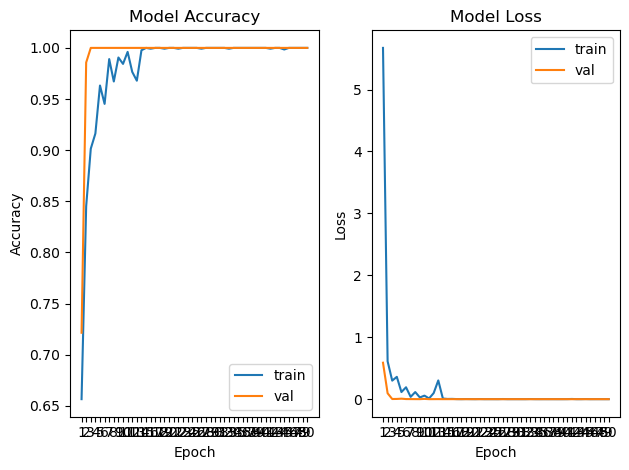

2024-02-18 00:10:18.605411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 2s 79ms/step


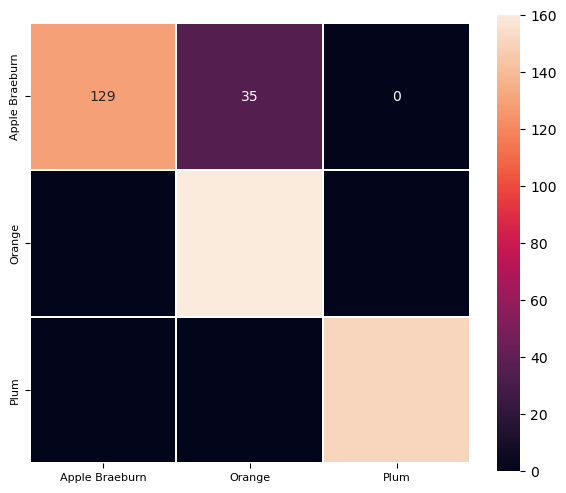

In [9]:
input_shape = (100, 100, 3)
num_classes = 3

model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="model")